In [1]:
!pip install keras-tcn

Looking in indexes: https://pypi.org/simple, https://us-python.pkg.dev/colab-wheels/public/simple/
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 591.0/591.0 kB 19.9 MB/s eta 0:00:00


In [2]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
from tcn import TCN, tcn_full_summary
from tensorflow.keras.layers import Dense, Dropout
from tensorflow.keras.models import Sequential
from sklearn.preprocessing import MinMaxScaler
from keras.preprocessing.sequence import TimeseriesGenerator
scaler = MinMaxScaler()

In [4]:
df = pd.read_excel("DJIA Realized Volatility.xlsx",index_col='Date',parse_dates=True)
df_for_date=df[int(len(df['Realised'])*0.7):].reset_index()

In [5]:
def df_to_X_y(window_size,test,scaled_test_input):
  X=[]
  for i in range(len(test)):
    row = [[a] for a in scaled_test_input[i:i+window_size]]
    X.append(row)
  return np.array(X)

Epoch: 10 | Inputs: 84 | Kernel: 6 | Dropout: 0.2 | Loss: mae

# H=1 Forecasts

In [6]:
RMSE = []
Accuracy = []
Quasilikelihood=[]

In [7]:
for i in range (15):
  n_features = 2
  n_input = 84
  train = df.iloc[:int(len(df['Realised'])*0.7)]
  train = train[int(len(train)*0.5):]
  test = df.iloc[int(len(df['Realised'])*0.7)-n_input:]
  scaler.fit(train)
  scaled_train_input = scaler.transform(train)
  scaled_test_input = scaler.transform(test)
  train = df["Realised"].iloc[:int(len(df['Realised'])*0.7)]
  train = train[int(len(train)*0.5):]
  test = df["Realised"].iloc[int(len(df['Realised'])*0.7):]
  train = train.array.reshape(-1, 1)
  test = test.array.reshape(-1, 1)
  scaler.fit(train)
  scaled_train_target = scaler.transform(train)
  scaled_test_target = scaler.transform(test)
  generator = TimeseriesGenerator(scaled_train_input, scaled_train_target, length=n_input, batch_size=32)
  model = Sequential()
  model.add(TCN(kernel_size=6, dilations=[1,2,4,1], nb_stacks=1,padding='causal',
                dropout_rate=0.2,activation='relu',kernel_initializer='he_normal', input_shape=(n_input, n_features)))
  model.add(Dense(1))
  model.compile(optimizer='adam', loss='mae', metrics=["accuracy", "mean_absolute_error"])
  model.fit(generator,epochs=10)
  X = df_to_X_y(n_input,test,scaled_test_input)
  X=X.reshape(len(test), n_input, n_features)
  y_hat=model.predict(X)
  true_predictions = scaler.inverse_transform(y_hat)
  RMSE.append(np.sum(np.sqrt((test-true_predictions)**2))/len(test))
  Accuracy.append((1-np.sum(np.sqrt((test-true_predictions)**2)/test)/(len(test)))*100)
  Quasilikelihood.append(np.sum(true_predictions/test-np.log(true_predictions/test)-1)/len(test))

Epoch 1/10
62/62 [==============================] - 15s 16ms/step - loss: 0.2470 - accuracy: 5.0968e-04 - mean_absolute_error: 0.2470
Epoch 2/10
62/62 [==============================] - 1s 11ms/step - loss: 0.0580 - accuracy: 5.0968e-04 - mean_absolute_error: 0.0580
Epoch 3/10
62/62 [==============================] - 1s 8ms/step - loss: 0.0449 - accuracy: 5.0968e-04 - mean_absolute_error: 0.0449
Epoch 4/10
62/62 [==============================] - 0s 8ms/step - loss: 0.0377 - accuracy: 5.0968e-04 - mean_absolute_error: 0.0377
Epoch 5/10
62/62 [==============================] - 1s 8ms/step - loss: 0.0372 - accuracy: 5.0968e-04 - mean_absolute_error: 0.0372
Epoch 6/10
62/62 [==============================] - 1s 8ms/step - loss: 0.0359 - accuracy: 5.0968e-04 - mean_absolute_error: 0.0359
Epoch 7/10
62/62 [==============================] - 1s 8ms/step - loss: 0.0352 - accuracy: 5.0968e-04 - mean_absolute_error: 0.0352
Epoch 8/10
62/62 [==============================] - 1s 8ms/step - loss: 0

In [8]:
Accuracy

[65.48500594783708,
 61.03514799254328,
 65.09436915749912,
 67.91069091860678,
 67.21503906010908,
 64.93059036354174,
 67.9903838681445,
 67.21938804076193,
 66.83716388202672,
 66.50728058714115,
 63.091654154349285,
 68.07166855343402,
 64.19940393316104,
 65.74015065449026,
 63.93309119638826]

In [9]:
RMSE

[0.0025564769374546705,
 0.002654709238002344,
 0.0025470318096645333,
 0.0025929341485812253,
 0.0027020781321022477,
 0.0025427684925469663,
 0.0027700868303920036,
 0.0025387242124631365,
 0.0028972855657262084,
 0.0026177568318998825,
 0.002557355746362095,
 0.0025974829298453235,
 0.002579615445852344,
 0.002654220704195686,
 0.002569390403963273]

In [10]:
Quasilikelihood

[0.09261016529615551,
 0.10502564799916096,
 0.09109256866339897,
 0.08849773709863336,
 0.09158767918626805,
 0.0927445960712983,
 0.09237131800621882,
 0.08576111158146324,
 0.10196437163108071,
 0.09009148216571544,
 0.09879896455083356,
 0.08655497937168614,
 0.09525225976038461,
 0.09345423030644276,
 0.096855037985366]

In [11]:
df_for_date=df[int(len(df['Realised'])*0.7):].reset_index()

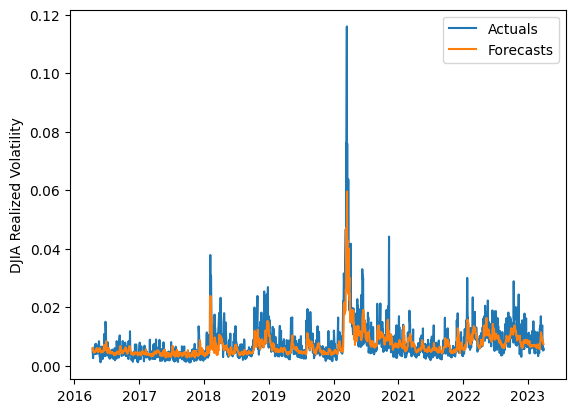

In [12]:
# Best model
plt.plot(df_for_date["Date"], test)
plt.plot(df_for_date["Date"], true_predictions) 
plt.ylabel("DJIA Realized Volatility")
plt.legend(['Actuals', 'Forecasts'])

# H=3 Forecasts

In [13]:
RMSE = []
Accuracy = []
Quasilikelihood=[]

In [14]:
def df_to_X_y(window_size,test,scaled_test_input):
  X=[]
  y=[]
  for i in range(int(len(test)/3)):
    row = [[a] for a in scaled_test_input[i*3:(i*3)+window_size]]
    X.append(row)
  return np.array(X)

In [15]:
for i in range (15):
  n_features = 2
  n_input = 84
  train = df.iloc[:int(len(df['Realised'])*0.7)]
  train = train[int(len(train)*0.5):]
  test = df.iloc[int(len(df['Realised'])*0.7)-n_input:]
  scaler.fit(train)
  scaled_train_input = scaler.transform(train)
  scaled_test_input = scaler.transform(test)
  train = df["Realised"].iloc[:int(len(df['Realised'])*0.7)]
  train = train[int(len(train)*0.5):]
  test = df["Realised"].iloc[int(len(df['Realised'])*0.7):]
  train = train.array.reshape(-1, 1)
  test = test.array.reshape(-1, 1)
  scaler.fit(train)
  scaled_train_target = scaler.transform(train)
  scaled_test_target = scaler.transform(test)
  generator = TimeseriesGenerator(scaled_train_input, scaled_train_target, length=n_input, batch_size=32)
  model = Sequential()
  model.add(TCN(kernel_size=6, dilations=[1,2,4,1], nb_stacks=1,padding='causal',
                dropout_rate=0.2,activation='relu',kernel_initializer='he_normal', input_shape=(n_input, n_features)))
  model.add(Dense(3))
  model.compile(optimizer='adam', loss='mae', metrics=["accuracy", "mean_absolute_error"])
  model.fit(generator,epochs=10)
  X = df_to_X_y(n_input,test,scaled_test_input)
  X=X.reshape(int(((len(test)/3))), n_input, n_features)
  y_hat=model.predict(X)
  y_hat=y_hat.reshape(len(test),1)
  true_predictions = scaler.inverse_transform(y_hat)
  RMSE.append(np.sum(np.sqrt((test-true_predictions)**2))/len(test))
  Accuracy.append((1-np.sum(np.sqrt((test-true_predictions)**2)/test)/(len(test)))*100)
  Quasilikelihood.append(np.sum(true_predictions/test-np.log(true_predictions/test)-1)/len(test))

Epoch 1/10
62/62 [==============================] - 6s 8ms/step - loss: 0.2263 - accuracy: 0.3109 - mean_absolute_error: 0.2263
Epoch 2/10
62/62 [==============================] - 1s 8ms/step - loss: 0.0479 - accuracy: 0.3298 - mean_absolute_error: 0.0479
Epoch 3/10
62/62 [==============================] - 1s 8ms/step - loss: 0.0399 - accuracy: 0.3364 - mean_absolute_error: 0.0399
Epoch 4/10
62/62 [==============================] - 1s 8ms/step - loss: 0.0378 - accuracy: 0.3333 - mean_absolute_error: 0.0378
Epoch 5/10
62/62 [==============================] - 1s 8ms/step - loss: 0.0363 - accuracy: 0.2905 - mean_absolute_error: 0.0363
Epoch 6/10
62/62 [==============================] - 1s 8ms/step - loss: 0.0350 - accuracy: 0.3293 - mean_absolute_error: 0.0350
Epoch 7/10
62/62 [==============================] - 1s 8ms/step - loss: 0.0337 - accuracy: 0.3226 - mean_absolute_error: 0.0337
Epoch 8/10
62/62 [==============================] - 1s 8ms/step - loss: 0.0337 - accuracy: 0.3690 - mean

In [16]:
RMSE

[0.002684398815955651,
 0.0027166345442522994,
 0.002720087225947544,
 0.002693155424473171,
 0.002640419622971612,
 0.0029138017322813143,
 0.0028262132297272456,
 0.0026942558209888915,
 0.0026755586695764036,
 0.002631695994592055,
 0.002619827667973373,
 0.0026352071216297775,
 0.002669890120042856,
 0.002689418973332584,
 0.002693043571927565]

In [17]:
Accuracy

[60.03646427938093,
 59.48479297518659,
 63.14510706945682,
 66.3175351094041,
 62.47953667378785,
 65.72459645263098,
 65.69684518390598,
 66.3220257948847,
 60.007738348930275,
 64.46218946715777,
 62.000677815406256,
 62.96934501725742,
 63.0177592693837,
 63.0641256521026,
 63.773801482734214]

In [18]:
Quasilikelihood

[0.11036464733865864,
 0.11289159527030404,
 0.10285117059748257,
 0.09468005026176657,
 0.10228851732625092,
 0.10330445448565266,
 0.10154276137976186,
 0.09539654860513162,
 0.11077018714519547,
 0.09696799247439969,
 0.10169724658463956,
 0.09989119614780984,
 0.10189860357674084,
 0.10147209149309526,
 0.10279775898903806]

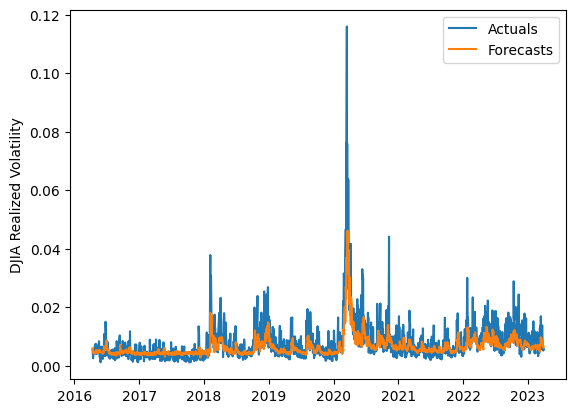

In [19]:
# Best model
plt.plot(df_for_date["Date"], test)
plt.plot(df_for_date["Date"], true_predictions) 
plt.ylabel("DJIA Realized Volatility")
plt.legend(['Actuals', 'Forecasts'])

# H=5 Forecasts

In [20]:
RMSE = []
Accuracy = []
Quasilikelihood=[]

In [21]:
def df_to_X_y(window_size,test,scaled_test_input):
  X=[]
  y=[]
  for i in range(int(len(test)/5)):
    row = [[a] for a in scaled_test_input[i*5:(i*5)+window_size]]
    X.append(row)
  return np.array(X)

In [22]:
for i in range (15):
  n_features = 2
  n_input = 84
  train = df.iloc[:int(len(df['Realised'])*0.7)]
  train = train[int(len(train)*0.5):]
  test = df.iloc[int(len(df['Realised'])*0.7)-n_input:]
  scaler.fit(train)
  scaled_train_input = scaler.transform(train)
  scaled_test_input = scaler.transform(test)
  train = df["Realised"].iloc[:int(len(df['Realised'])*0.7)]
  train = train[int(len(train)*0.5):]
  test = df["Realised"].iloc[int(len(df['Realised'])*0.7):]
  train = train.array.reshape(-1, 1)
  test = test.array.reshape(-1, 1)
  scaler.fit(train)
  scaled_train_target = scaler.transform(train)
  scaled_test_target = scaler.transform(test)
  generator = TimeseriesGenerator(scaled_train_input, scaled_train_target, length=n_input, batch_size=32)
  model = Sequential()
  model.add(TCN(kernel_size=6, dilations=[1,2,4,1], nb_stacks=1,padding='causal',
                dropout_rate=0.2,activation='relu',kernel_initializer='he_normal', input_shape=(n_input, n_features)))
  model.add(Dense(5))
  model.compile(optimizer='adam', loss='mae', metrics=["accuracy", "mean_absolute_error"])
  model.fit(generator,epochs=10)
  X = df_to_X_y(n_input,test,scaled_test_input)
  X=X.reshape(int(((len(test)/5))), n_input, n_features)
  y_hat=model.predict(X)
  y_hat=y_hat.reshape(len(test),1)
  true_predictions = scaler.inverse_transform(y_hat)
  RMSE.append(np.sum(np.sqrt((test-true_predictions)**2))/len(test))
  Accuracy.append((1-np.sum(np.sqrt((test-true_predictions)**2)/test)/(len(test)))*100)
  Quasilikelihood.append(np.sum(true_predictions/test-np.log(true_predictions/test)-1)/len(test))

Epoch 1/10
62/62 [==============================] - 5s 9ms/step - loss: 0.1521 - accuracy: 0.2080 - mean_absolute_error: 0.1521
Epoch 2/10
62/62 [==============================] - 1s 8ms/step - loss: 0.0420 - accuracy: 0.2732 - mean_absolute_error: 0.0420
Epoch 3/10
62/62 [==============================] - 1s 9ms/step - loss: 0.0377 - accuracy: 0.2411 - mean_absolute_error: 0.0377
Epoch 4/10
62/62 [==============================] - 1s 9ms/step - loss: 0.0358 - accuracy: 0.2396 - mean_absolute_error: 0.0358
Epoch 5/10
62/62 [==============================] - 1s 11ms/step - loss: 0.0340 - accuracy: 0.3012 - mean_absolute_error: 0.0340
Epoch 6/10
62/62 [==============================] - 1s 11ms/step - loss: 0.0345 - accuracy: 0.2538 - mean_absolute_error: 0.0345
Epoch 7/10
62/62 [==============================] - 1s 11ms/step - loss: 0.0338 - accuracy: 0.2543 - mean_absolute_error: 0.0338
Epoch 8/10
62/62 [==============================] - 1s 8ms/step - loss: 0.0325 - accuracy: 0.3165 - m

In [23]:
RMSE

[0.002715049461133066,
 0.002805781087626082,
 0.002887053431265412,
 0.002747126218224127,
 0.0027311388523361593,
 0.0028054693026043223,
 0.002716756459322107,
 0.0028894989545875395,
 0.002802852086005425,
 0.0027054907986360887,
 0.0027420665860982975,
 0.002737791773481771,
 0.002793724131293398,
 0.002668271453854347,
 0.002720946985952627]

In [24]:
Accuracy

[60.70822056412023,
 59.09402503147043,
 56.23756492336298,
 62.952597104450824,
 64.17331587951642,
 61.83474562380189,
 63.683455623826134,
 65.58116904077424,
 64.35564764592097,
 62.06824250734096,
 59.77247049833818,
 62.47201475652708,
 61.93808008328572,
 63.13808361863216,
 62.2189339408473]

In [25]:
Quasilikelihood

[0.11103978455257006,
 0.11794064165554444,
 0.12390671505621273,
 0.105122683307283,
 0.10154889856532966,
 0.11113156056482207,
 0.10303823978889455,
 0.10306151013782094,
 0.10503405014212873,
 0.10733680904328256,
 0.11312824123599735,
 0.10637402833961325,
 0.10935040723337051,
 0.10326766642198613,
 0.1067204639160982]

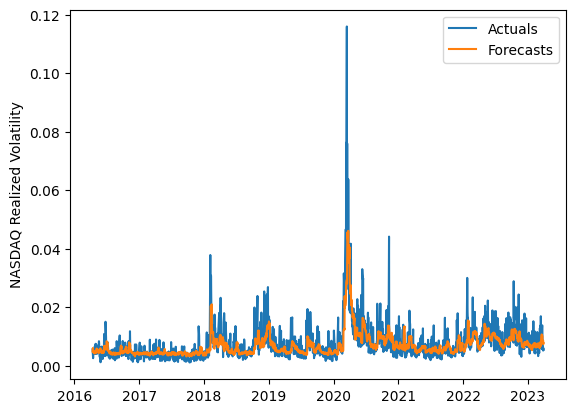

In [26]:
# Best model
plt.plot(df_for_date["Date"], test)
plt.plot(df_for_date["Date"], true_predictions) 
plt.ylabel("NASDAQ Realized Volatility")
plt.legend(['Actuals', 'Forecasts'])

# H=10 Forecasts

In [27]:
RMSE = []
Accuracy = []
Quasilikelihood=[]

In [28]:
def df_to_X_y(window_size,test,scaled_test_input):
  X=[]
  y=[]
  for i in range(int(len(test)/10)):
    row = [[a] for a in scaled_test_input[i*10:(i*10)+window_size]]
    X.append(row)
  return np.array(X)

In [29]:
for i in range (15):
  n_features = 2
  n_input = 84
  train = df.iloc[:int(len(df['Realised'])*0.7)]
  train = train[int(len(train)*0.5):]
  test = df.iloc[int(len(df['Realised'])*0.7)-n_input:]
  scaler.fit(train)
  scaled_train_input = scaler.transform(train)
  scaled_test_input = scaler.transform(test)
  train = df["Realised"].iloc[:int(len(df['Realised'])*0.7)]
  train = train[int(len(train)*0.5):]
  test = df["Realised"].iloc[int(len(df['Realised'])*0.7):]
  train = train.array.reshape(-1, 1)
  test = test.array.reshape(-1, 1)
  scaler.fit(train)
  scaled_train_target = scaler.transform(train)
  scaled_test_target = scaler.transform(test)
  generator = TimeseriesGenerator(scaled_train_input, scaled_train_target, length=n_input, batch_size=32)
  model = Sequential()
  model.add(TCN(kernel_size=6, dilations=[1,2,4,1], nb_stacks=1,padding='causal',
                dropout_rate=0.2,activation='relu',kernel_initializer='he_normal', input_shape=(n_input, n_features)))
  model.add(Dense(10))
  model.compile(optimizer='adam', loss='mae', metrics=["accuracy", "mean_absolute_error"])
  model.fit(generator,epochs=10)
  test=test[:len(test)-5]
  X = df_to_X_y(n_input,test,scaled_test_input)
  X=X.reshape(int(((len(test)/10))), n_input, n_features)
  y_hat=model.predict(X)
  y_hat=y_hat.reshape(len(test),1)
  true_predictions = scaler.inverse_transform(y_hat)
  RMSE.append(np.sum(np.sqrt((test-true_predictions)**2))/len(test))
  Accuracy.append((1-np.sum(np.sqrt((test-true_predictions)**2)/test)/(len(test)))*100)
  Quasilikelihood.append(np.sum(true_predictions/test-np.log(true_predictions/test)-1)/len(test))

Epoch 1/10
62/62 [==============================] - 5s 9ms/step - loss: 0.1642 - accuracy: 0.0872 - mean_absolute_error: 0.1642
Epoch 2/10
62/62 [==============================] - 0s 8ms/step - loss: 0.0423 - accuracy: 0.1030 - mean_absolute_error: 0.0423
Epoch 3/10
62/62 [==============================] - 1s 8ms/step - loss: 0.0380 - accuracy: 0.1121 - mean_absolute_error: 0.0380
Epoch 4/10
62/62 [==============================] - 1s 8ms/step - loss: 0.0380 - accuracy: 0.0810 - mean_absolute_error: 0.0380
Epoch 5/10
62/62 [==============================] - 1s 8ms/step - loss: 0.0364 - accuracy: 0.0571 - mean_absolute_error: 0.0364
Epoch 6/10
62/62 [==============================] - 1s 10ms/step - loss: 0.0348 - accuracy: 0.0846 - mean_absolute_error: 0.0348
Epoch 7/10
62/62 [==============================] - 1s 11ms/step - loss: 0.0357 - accuracy: 0.1432 - mean_absolute_error: 0.0357
Epoch 8/10
62/62 [==============================] - 1s 11ms/step - loss: 0.0350 - accuracy: 0.1335 - m

In [30]:
RMSE

[0.003067952835854847,
 0.0030497858197201526,
 0.0029310225703883725,
 0.003029005524741887,
 0.0030969071209273045,
 0.0029094679130326384,
 0.0029387797539404074,
 0.0030369256628069437,
 0.0029924960786766176,
 0.002909872258714747,
 0.003061177240629533,
 0.0029213598918920625,
 0.002966304571852568,
 0.003176800943680335,
 0.0029114448928746132]

In [31]:
Accuracy

[58.92039844448982,
 61.75292439919866,
 57.586210313633224,
 59.55896901257526,
 58.23435742224468,
 59.14553347318001,
 59.82886726329644,
 53.92574940164512,
 60.24378929859333,
 60.57787355706756,
 55.23928696308871,
 58.672592265635984,
 58.64790052492178,
 52.73775059036937,
 58.722847969218314]

In [32]:
Quasilikelihood

[0.1294926755369592,
 0.12012768309110121,
 0.12811351595207765,
 0.12534181383204854,
 0.13185843124096153,
 0.1223586728195574,
 0.12028529843524247,
 0.13915464514858708,
 0.12185544583274766,
 0.11839101482009504,
 0.1369203373953924,
 0.12476438358626112,
 0.126338704359782,
 0.14450767896578384,
 0.12433085801070176]

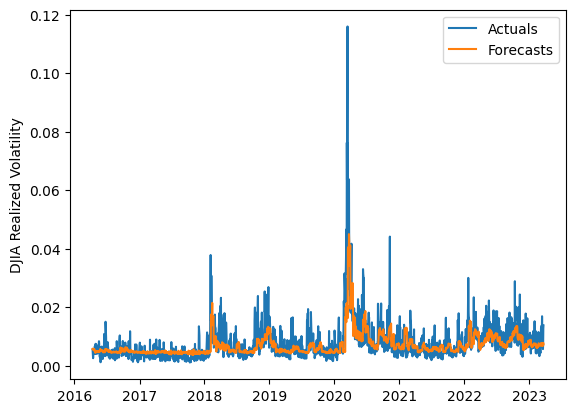

In [33]:
# Best model
plt.plot(df_for_date["Date"][:1750], test)
plt.plot(df_for_date["Date"][:1750], true_predictions) 
plt.ylabel("DJIA Realized Volatility")
plt.legend(['Actuals', 'Forecasts'])

# H=22 Forecasts

In [34]:
RMSE = []
Accuracy = []
Quasilikelihood=[]

In [35]:
def df_to_X_y(window_size,test,scaled_test_input):
  X=[]
  y=[]
  for i in range(int(len(test)/22)):
    row = [[a] for a in scaled_test_input[i*22:(i*22)+window_size]]
    X.append(row)
  return np.array(X)

In [36]:
for i in range (15):
  n_features = 2
  n_input = 84
  train = df.iloc[:int(len(df['Realised'])*0.7)]
  train = train[int(len(train)*0.5):]
  test = df.iloc[int(len(df['Realised'])*0.7)-n_input:]
  scaler.fit(train)
  scaled_train_input = scaler.transform(train)
  scaled_test_input = scaler.transform(test)
  train = df["Realised"].iloc[:int(len(df['Realised'])*0.7)]
  train = train[int(len(train)*0.5):]
  test = df["Realised"].iloc[int(len(df['Realised'])*0.7):]
  train = train.array.reshape(-1, 1)
  test = test.array.reshape(-1, 1)
  scaler.fit(train)
  scaled_train_target = scaler.transform(train)
  scaled_test_target = scaler.transform(test)
  generator = TimeseriesGenerator(scaled_train_input, scaled_train_target, length=n_input, batch_size=32)
  model = Sequential()
  model.add(TCN(kernel_size=6, dilations=[1,2,4,1], nb_stacks=1,padding='causal',
                dropout_rate=0.2,activation='relu',kernel_initializer='he_normal', input_shape=(n_input, n_features)))
  model.add(Dense(22))
  model.compile(optimizer='adam', loss='mae', metrics=["accuracy", "mean_absolute_error"])
  model.fit(generator,epochs=10)
  test=test[:len(test)-17]
  X = df_to_X_y(n_input,test,scaled_test_input)
  X=X.reshape(int(((len(test)/22))), n_input, n_features)
  y_hat=model.predict(X)
  y_hat=y_hat.reshape(len(test),1)
  true_predictions = scaler.inverse_transform(y_hat)
  RMSE.append(np.sum(np.sqrt((test-true_predictions)**2))/len(test))
  Accuracy.append((1-np.sum(np.sqrt((test-true_predictions)**2)/test)/(len(test)))*100)
  Quasilikelihood.append(np.sum(true_predictions/test-np.log(true_predictions/test)-1)/len(test))

Epoch 1/10
62/62 [==============================] - 5s 9ms/step - loss: 0.0868 - accuracy: 0.0459 - mean_absolute_error: 0.0868
Epoch 2/10
62/62 [==============================] - 1s 8ms/step - loss: 0.0400 - accuracy: 0.0673 - mean_absolute_error: 0.0400
Epoch 3/10
62/62 [==============================] - 1s 8ms/step - loss: 0.0364 - accuracy: 0.0550 - mean_absolute_error: 0.0364
Epoch 4/10
62/62 [==============================] - 1s 8ms/step - loss: 0.0344 - accuracy: 0.0673 - mean_absolute_error: 0.0344
Epoch 5/10
62/62 [==============================] - 0s 8ms/step - loss: 0.0340 - accuracy: 0.0642 - mean_absolute_error: 0.0340
Epoch 6/10
62/62 [==============================] - 0s 8ms/step - loss: 0.0325 - accuracy: 0.0601 - mean_absolute_error: 0.0325
Epoch 7/10
62/62 [==============================] - 1s 8ms/step - loss: 0.0331 - accuracy: 0.0663 - mean_absolute_error: 0.0331
Epoch 8/10
62/62 [==============================] - 1s 8ms/step - loss: 0.0320 - accuracy: 0.0143 - mean

3/3 [==============================] - 0s 6ms/step
Epoch 1/10
62/62 [==============================] - 5s 8ms/step - loss: 0.1116 - accuracy: 0.0255 - mean_absolute_error: 0.1116
Epoch 2/10
62/62 [==============================] - 1s 8ms/step - loss: 0.0427 - accuracy: 0.0423 - mean_absolute_error: 0.0427
Epoch 3/10
62/62 [==============================] - 1s 8ms/step - loss: 0.0383 - accuracy: 0.0280 - mean_absolute_error: 0.0383
Epoch 4/10
62/62 [==============================] - 1s 8ms/step - loss: 0.0369 - accuracy: 0.0240 - mean_absolute_error: 0.0369
Epoch 5/10
62/62 [==============================] - 1s 8ms/step - loss: 0.0344 - accuracy: 0.0469 - mean_absolute_error: 0.0344
Epoch 6/10
62/62 [==============================] - 1s 8ms/step - loss: 0.0337 - accuracy: 0.0520 - mean_absolute_error: 0.0337
Epoch 7/10
62/62 [==============================] - 1s 8ms/step - loss: 0.0346 - accuracy: 0.0214 - mean_absolute_error: 0.0346
Epoch 8/10
62/62 [==============================] - 1

3/3 [==============================] - 0s 7ms/step
Epoch 1/10
62/62 [==============================] - 5s 8ms/step - loss: 0.1240 - accuracy: 0.0586 - mean_absolute_error: 0.1240
Epoch 2/10
62/62 [==============================] - 1s 8ms/step - loss: 0.0420 - accuracy: 0.0377 - mean_absolute_error: 0.0420
Epoch 3/10
62/62 [==============================] - 1s 8ms/step - loss: 0.0370 - accuracy: 0.0352 - mean_absolute_error: 0.0370
Epoch 4/10
62/62 [==============================] - 1s 8ms/step - loss: 0.0355 - accuracy: 0.0229 - mean_absolute_error: 0.0355
Epoch 5/10
62/62 [==============================] - 1s 8ms/step - loss: 0.0343 - accuracy: 0.0153 - mean_absolute_error: 0.0343
Epoch 6/10
62/62 [==============================] - 1s 8ms/step - loss: 0.0343 - accuracy: 0.0285 - mean_absolute_error: 0.0343
Epoch 7/10
62/62 [==============================] - 1s 8ms/step - loss: 0.0326 - accuracy: 0.0153 - mean_absolute_error: 0.0326
Epoch 8/10
62/62 [==============================] - 1

In [41]:
RMSE

[0.003464680968797097,
 0.0035319887627103213,
 0.0034114475270479337,
 0.0034518550884963706,
 0.0033047659173651572,
 0.0033516964858265647,
 0.0032470335301614975,
 0.003299762849235686,
 0.0034491357492432207,
 0.003317868672604583,
 0.0032753616281845934,
 0.0034001655806455023,
 0.0033046344941489846,
 0.0033611441434060222,
 0.003259964414893647]

In [42]:
Accuracy

[51.96804405713353,
 52.335324215330644,
 51.5954500082912,
 50.96567012599756,
 54.75246541571999,
 56.73327167348198,
 54.77004973562273,
 57.23526599275887,
 52.918286747544215,
 57.69897332578121,
 54.670273788015734,
 53.844122521208874,
 56.43568920499453,
 57.19749099534689,
 55.38766662061194]

In [43]:
Quasilikelihood

[0.15764923373797268,
 0.15598214667581178,
 0.15739763750872507,
 0.16087368230956417,
 0.14627304627707194,
 0.14344338153424824,
 0.14958161810411477,
 0.14116899395300145,
 0.15521151241238207,
 0.1413966671341494,
 0.14692809996884001,
 0.15200501532336633,
 0.14052754417347543,
 0.1445282427557468,
 0.14377374339621193]

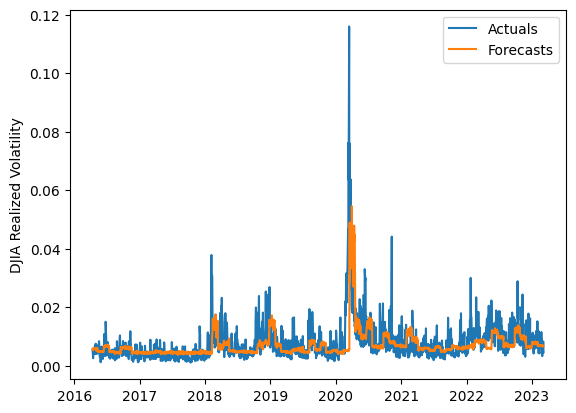

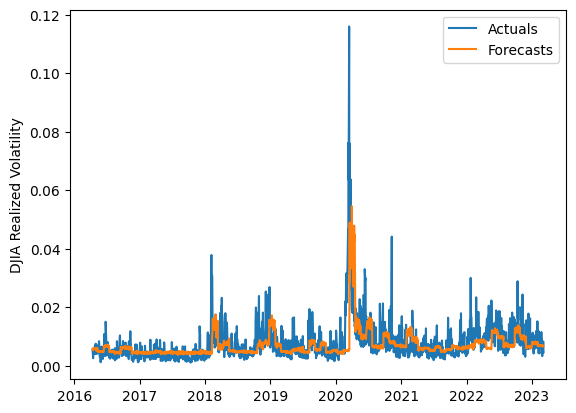

In [40]:
# Best model
plt.plot(df_for_date["Date"][:1738], test)
plt.plot(df_for_date["Date"][:1738], true_predictions) 
plt.ylabel("DJIA Realized Volatility")
plt.legend(['Actuals', 'Forecasts'])